## Import

In [1]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs')
except:
  pass

## Create Dataset

In [2]:
# downlaod dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# need to synthesise MNIST dataset before we can use it
def create_example(x, y):
    # colour label -- converting black-and-white to RGB
    c = np.random.randint(0, 2)
    image = 0.5 * np.random.rand(28, 28, 3) # 28x28 is the dimension of each example in MNIST and 3 is for colour
    image[:, :, c] += 0.5 * x / 225.
    return image, y, c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


digit: 4, colour: green


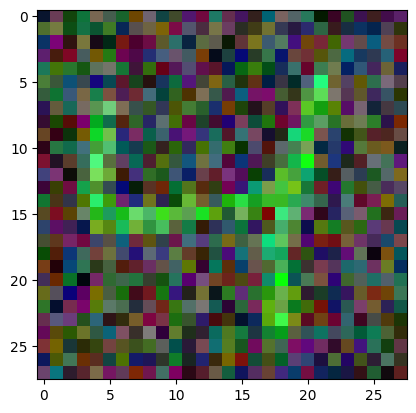

In [4]:
colours = {0: 'red', 1: 'green'}

index = 2
x, y, c = create_example(x_train[index], y_train[index])
print(f"digit: {y}, colour: {colours[c]}")

plt.imshow(x)
plt.show()

## Dataset Generator

In [13]:
# generator for training and testing

def generate_data(x, y, batch_size=32):
    num_examples = len(y)

    while True:
        x_batch = np.zeros((batch_size, 28, 28, 3))
        y_batch = np.zeros((batch_size,))
        c_batch = np.zeros((batch_size,))

        for i in range(0, batch_size):
            index = np.random.randint(0, num_examples)
            image, digit, colour = create_example(x[index], y[index])
            x_batch[i], y_batch[i], c_batch[i] = image, digit, colour
        
        yield x_batch, (y_batch, c_batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


digit: [5.], colour: [1.]


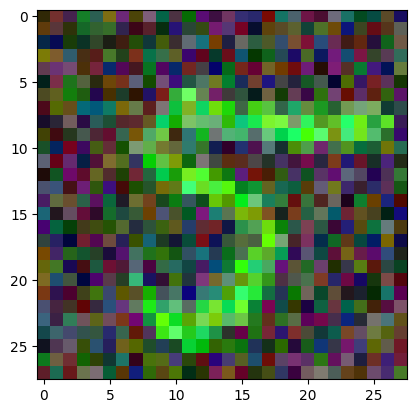

In [6]:
# test generator

x, [y, c] = next(generate_data(x_test, y_test, batch_size=1))
print(f"digit: {y}, colour: {c}")

plt.imshow(x[0])
plt.show()

## Create Model

In [15]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Add, Dense

input_ = Input(shape=(28, 28, 3), name='input')
conv_1 = Conv2D(32, 3, name='conv_1')(input_)
act_1 = Activation('relu', name='act_1')(conv_1)

pool_1 = MaxPool2D(4, name='pool_1')(act_1)
flat_1 = Flatten(name='flat_1')(pool_1)

colour = Dense(1, activation='sigmoid', name='colour')(flat_1)

conv_2 = Conv2D(32, 3, padding='same', name='conv_2')(act_1)
act_2 = Activation('relu', name='act_2')(conv_2)

conv_3 = Conv2D(32, 3, padding='same', name='conv_3')(act_2)
# skip connection (just for show, not really needed here)
add = Add(name='add')([act_1, conv_3])
act_3 = Activation('relu', name='act_3')(add)

pool_2 = MaxPool2D(4, name='pool_2')(act_3)
flat_2 = Flatten(name='flat_2')(pool_2)

digit = Dense(10, activation='softmax', name='digit')(flat_2)

model = tf.keras.models.Model(input_, [digit, colour])
model.compile(
    loss={
        'digit': 'sparse_categorical_crossentropy',
        'colour': 'binary_crossentropy'
    },
    optimizer='adam',
    metrics=[['accuracy'], ['accuracy']]
)

model.summary()
# note that this model has 32K parameters and a complex structure, not as straightforward as a regular neural network for a task like this
# exploratory project to understand how complex models can be created functionally in Keras

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 28, 28, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 26, 26,    │        896 │ input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act_1 (Activation)  │ (None, 26, 26,    │          0 │ conv_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 26, 26,    │      9,248 │ act_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act_2 (Activation)  │ (None, 26, 26,    │          0 │ conv_2[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 26, 26,    │      9,248 │ act_2[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 26, 26,    │          0 │ act_1[0][0],      │
│                     │ 32)               │            │ conv_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ act_3 (Activation)  │ (None, 26, 26,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_2              │ (None, 6, 6, 32)  │          0 │ act_3[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_1              │ (None, 6, 6, 32)  │          0 │ act_1[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flat_2 (Flatten)    │ (None, 1152)      │          0 │ pool_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flat_1 (Flatten)    │ (None, 1152)      │          0 │ pool_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit (Dense)       │ (None, 10)        │     11,530 │ flat_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ colour (Dense)      │ (None, 1)         │      1,153 │ flat_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,075 (125.29 KB)

 Trainable params: 32,075 (125.29 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Training the Model

In [19]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    colour_accuracy = logs.get('colour_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_colour_accuracy = logs.get('val_colour_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, colour_accuracy: {colour_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_colour_accuracy: {val_colour_accuracy:.2f}')

In [20]:
train_gen = generate_data(x_train, y_train)
test_gen = generate_data(x_test, y_test)

_ = model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=200,
    validation_steps=100,
    epochs=10,
    callbacks=[
        Logger(),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ],
    verbose=False
)

============================== 1 ==============================
digit_accuracy: 0.89, colour_accuracy: 1.00
val_digit_accuracy: 0.93, val_colour_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.93, colour_accuracy: 1.00
val_digit_accuracy: 0.95, val_colour_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.95, colour_accuracy: 1.00
val_digit_accuracy: 0.94, val_colour_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.95, colour_accuracy: 1.00
val_digit_accuracy: 0.97, val_colour_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.96, colour_accuracy: 1.00
val_digit_accuracy: 0.96, val_colour_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.96, colour_accuracy: 1.00
val_digit_accuracy: 0.97, val_colour_accuracy: 1.00
============================== 7 =======

In [21]:
%tensorboard --logdir logs

## Final Predictions

In [23]:
def test_model(show=True):
  x, [y, c] = next(test)

  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])

  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colours[gt_color]}')
    print(f'Pr: {pred_digit}, {colours[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colours[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colours[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/var/folders/59/72y8myms69n5htzd5skpcty40000gn/T/ipykernel_46404/2079700352.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_color = int(preds[1] > 0.5)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GT: 0, red
Pr: 0, red


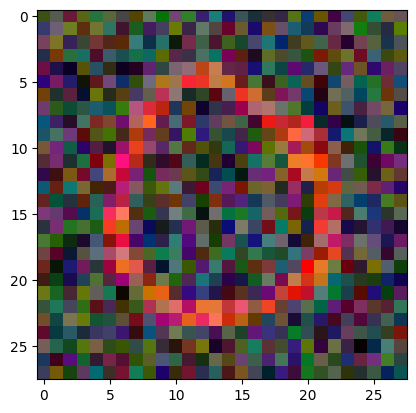

In [28]:
test_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/var/folders/59/72y8myms69n5htzd5skpcty40000gn/T/ipykernel_46404/2079700352.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_color = int(preds[1] > 0.5)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


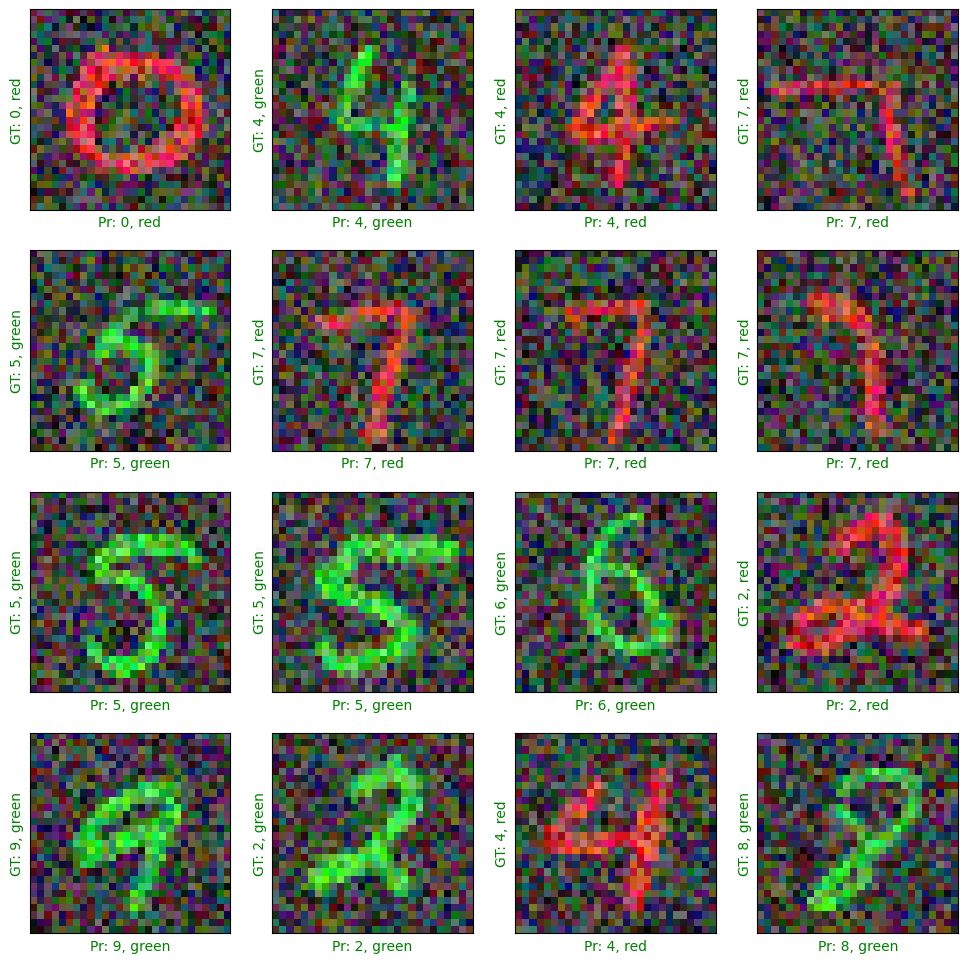

In [30]:
plt.figure(figsize=(12, 12))

for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    test_model(show=False)

plt.show()